# RNN Example

- **Instructor**: Jongwoo Lim / Jiun Bae
- **Email**: [jlim@hanyang.ac.kr](mailto:jlim@hanyang.ac.kr) / [jiunbae.623@gmail.com](mailto:jiunbae.623@gmail.com)

## Sequential data prediction

If you are using a neural network to solve the problem of predicting a sequence, such as sentence or time series data, the size of the vector representing the sequence if you want the values you want to predict depend on older, older data. Should be increased.

## RNN (Recurrent Neural Network)

RNN (Recurrent Neural Network) is a neural network structure that can predict long sequences by storing the state of a neuron and using it as input in the next step. Here, we will look at the basic structure of RNN and how to implement RNN supported by the Keras Python package.


The general feedforward neural network structure is shown as the result of applying the activation function $\sigma$ to the product of the output vector $y$, the input $x$ vector and the neural network weight matrix $U$ as follows.

$$\sigma(Ux)$$

In the case of MLP (Multi-Layer Perceptron) having one hidden layer, it can be expressed as follows:

$$h = \sigma(Ux)$$
$$o = \sigma(Vh)$$

In this equation, $h$ is the hidden layer vector, $o$ is the output vector, $U$ is the weight matrix from the input to the hidden layer, and $V$ is the weight matrix from the hidden layer to the output.


RNN outputs a status vector $s$ in addition to the output vector $o$. The state vector is similar to a kind of hidden layer vector, but depends on the input vector as well as the previous state vector value. The output vector depends on the value of the state vector.

$$s_t = \sigma(Ux_t + Ws_{t-1})$$
$$o_t = \sigma(Vs_t)$$

RNN has a similar effect to MLP, which has an infinite number of hidden layers when connected and unfolded according to time steps. The figure is as follows.

![rnn](../assets/rnn.png)

The difference is that RNN can process time series data because the state changes from the previous input. The status of the input sequence may change depending on the sequence of the input vectors.

It can be divided into the following according to the type of input and result.

![sequentail](../assets/sequential.png)

# Code

In [136]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## Dataset

$Sin$ function prediction
$$y = sin(x)$$

In [126]:
size = 1000

In [127]:
x_ = np.arange(size)
y_ = np.sin(np.pi * .125 * x_)

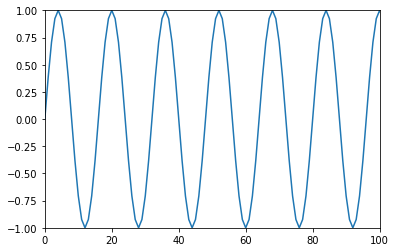

In [137]:
plt.plot(y_)
plt.xlim(0, 100)
plt.ylim(-1, 1)
plt.show()

In [138]:
input_size = 5
hidden_size = 30
batch_size = 32
num_layers = 1
length = 4

In [139]:
train_x = np.empty((size - input_size, input_size))
train_y = np.empty((size - input_size, 1))

In [140]:
for x in x_[:-input_size]:
    train_x[x] = y_[x:x + input_size]
    train_y[x] = y_[x + input_size]

### First train data and label

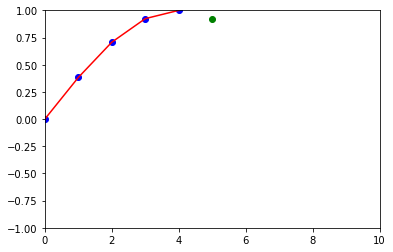

In [141]:
plt.plot(train_x[0], c='r')
plt.scatter(np.arange(input_size), train_x[0], c='b')
plt.scatter((input_size,), train_y[0], c='g')
plt.xlim(0, 10)
plt.ylim(-1, 1)
plt.show()

## Simple RNN Model

Network forwards RNN and fc

![sequential-figure](../assets/sequential-figure.png)

In [207]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, bias=True, batch_first=True, 
                          nonlinearity='tanh', dropout=0)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, inputs, hiddens):
        out, hidden = self.rnn(inputs, hiddens)
        out = self.fc(out)
        
        return out, hidden

    def hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [208]:
model = RNN(input_size, hidden_size)

### Before training

Prediction of un trained model

In [209]:
hiddens = model.hidden()
preds = [
    model(torch.Tensor(train_x[x]).view(1, 1, 5), hiddens)[0].item()
    for x in x_[:-input_size]
]

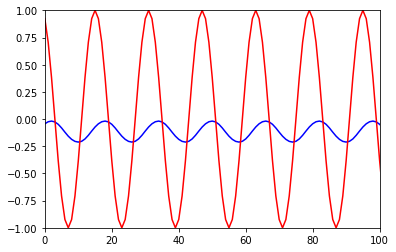

In [210]:
plt.plot(preds, c='b')
plt.plot(train_y, c='r')
plt.xlim(0, 100)
plt.ylim(-1, 1)
plt.show()

## Train

### (Optional) Visualize MNIST Dataset

This code is just show MNIST data (code is not important!)

In [ ]:
from PIL import Image  # PIL is Python Image Library 

n = 5                  # 5 x 5 matrix
size = 28              # Each image is 28 x 28

result = Image.new('L', (size * n, size * n))
for i, idx in enumerate(np.random.choice(len(TRAIN_DATASET), n * n)):
    x = i // n * size
    y = i % n * size
    result.paste(TRAIN_DATASET[idx][0], (x, y, x + size, y + size))
    
result

## FC Network

This is a simple two convolution layer network. The code is quite easy.
Just fallow `forward` function. `torch.nn.functional` and `torch.nn` support many useful function and layer for build network.
(See offical [doc](https://pytorch.org/docs/stable/nn.html#torch-nn-functional) for more information)

`nn.Linear` is linear transformation as `y=ax+b`.

![fully connected](../assets/fullyconnected.jpg)

In **PyTorch**, the fc layer can be defined as follow:

```
nn.Linear(
    in_features,
    out_features,
    bias=True
)
```

# Q1. FC(fully-connected) Model

Fill in the blanks to create the following network model.

- FC1 (input: 28*28, output: 392)
- FC2 (input: 392, output: 10, class number of digit)

In [ ]:
class FCNetwork(nn.Module):
    """Simple Neural Network contains fc layer
    """
    def __init__(self):
        super(FCNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, ?)
        self.fc2 = nn.Linear(?, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [ ]:
FCNetwork()

### Single fc step

Running a fully connected layer one step is equivalent to doing $wx+b$.

In [ ]:
image, _ = next(iter(TRAIN_DATASET))
image_tensor = torch.Tensor(np.array(image)).reshape(1, -1)

layer = nn.Linear(784, 10)

In [ ]:
layer.forward(image_tensor)

In [ ]:
torch.matmul(layer.weight, image_tensor.T).T + layer.bias

## Conv Network

This is a simple two convolution layer network. The code is quite easy.
Just fallow `forward` function. `torch.nn.functional` and `torch.nn` support many useful function and layer for build network.
(See offical [doc](https://pytorch.org/docs/stable/nn.html#torch-nn-functional) for more information)

`nn.Conv2d` is 2-dimentional convolutaion layer.

`nn.Linear` is linear transformation as `y=ax+b`.

`F.relu` apply ReLU activation function.

`F.max_pool2d` apply 2-dimentional max-pooling.

## `convolution` layer

![convolution layer](../assets/convolution.png)

![convolution layer gif](../assets/convolution.gif)

## `maxpool` layer

![maxpool layer](../assets/maxpool.jpeg)

In **PyTorch**, the convolution layer can be defined as follow:

```
nn.Conv2d(
    in_channels,
    out_channels,
    kernel_size,
    stride=1,
    padding=0,
    dilation=1,
    groups=1,
    bias=True,
    padding_mode='zeros',
)
```

# Q2. Convolution Model

Fill in the blanks to create the following network model.

- Conv1 (input: 1, output: 20, kernel: 5, stride: 1)
- ReLU
- MaxPool
- Conv2 (input: 20, output: 50, kernel: 5, stride: 1)
- ReLU
- MaxPool
- FC1 (input: 4x4x50, output: 500)
- ReLU
- FC2 (input: 500, output: 10, class number of digit)

In [ ]:
class ConvNetwork(nn.Module):
    """Simple Neural Network contains conv layer and fc layer
    """
    def __init__(self):
        super(ConvNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, ?, 5, 1)
        self.conv2 = nn.Conv2d(?, ?, 5, 1)
        self.fc1 = nn.Linear(?, ?)
        self.fc2 = nn.Linear(?, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, ?)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
ConvNetwork()

# Q3. Conv layer output shape

We can predict the output shape of the convolution layer by considering variables such as `kernel size`, `stride`, and `padding`.

In [ ]:
image, _ = next(iter(TRAIN_DATASET))
# change dimension from (28, 28) to (1, 1, 28, 28)
# Generally, the input of a machine learning model is (batch_size, channel, width, height).
image_tensor = torch.Tensor(np.array(image)).unsqueeze_(0).unsqueeze_(0)

layer = nn.Conv2d(1, 20, kernel_size=5, stride=1)

### Before executing below the cell, guess output shape

In [ ]:
layer.forward(image_tensor).shape

# Q4. Max pooling layer

- Why using maxpooling between convolution layers?
- Why using maxpooling? not average-pooling or min-pooling

In [ ]:
x = torch.Tensor(np.array(((1, 2), (3, 4)))).unsqueeze_(0).unsqueeze_(0)
F.max_pool2d(x, 2, 2)

## Define Train and Test functions

In train scope, we put the data to model, compute loss and update parameters. That's all we have to do.
To put data into the model, you call the model as a function that takes data as arguments. (see `output = model(data)`)
**PyTorch** provide many loss function. `nll_loss` is the *negative log likelihood loss*. compute loss using output and target(label).
Calling `.backward()` accumulates the gradient for each parameters.
Finally, call `optimizer.step()` to update optimizer.


In test scope, evaluate model using test set which not contained in a train set.
`pred = output.argmax(dim=1, keepdim=True)` is change output to digit-class for comparing to target(label).
`pred.eq(target.view_as(pred)).sum().item()` calculate correct answer count.


`model.train` and `model.test` means set `model` for train or test. In train scope set parameters trainable and test scope not update parameters.
So, if you want to update parameters, must call `model.train` before pass data to the model.

*`data.to(device)` and `target.to(device)` mean change data to device(gpu if available else cpu)*

In [ ]:
from typing import Tuple

def train(model, device, train_loader, optimizer) -> float:
    """Train function

        Arguments:
            model (nn.Module): some networks extends from ``nn.Module``.
            device (torch.device): device for use CUDA if available.
            train_loader (torch.utils.data.dataloader.DataLoader): train data loader.
            optimizer (torch.optim): optimizer

        Returns: loss (float)
    """
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # move memory to target device
        data, target = data.to(device), target.to(device)
    
        # optimizer initialize
        optimizer.zero_grad()
        
        # forward pass
        output = model(data)
        
        # calculate loss
        loss = F.nll_loss(output, target)
        
        # backward pass
        loss.backward()
        
        # update
        optimizer.step()

    return loss.item()


def test(model, device, test_loader) -> Tuple[float, float, torch.Tensor]:
    """Test function

        Arguments:
            model (nn.Module): some networks extends from ``nn.Module``.
            device (torch.device): device for use CUDA if available.
            test_loader (torch.utils.data.dataloader.DataLoader): test data loader.

        Returns: tuple of below three
            test_loss: 
            accuracy: 
            output: 
    """
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy, output

## Run!


### Reproducible (**Important**)

**Reproducible** is very **very** ***very*** important in experiment. An experiment that can not be reproduced can not make any conclusions. So fix random seed before anything else.
In **PyTorch** just call `torch.manual_seed` for fix random seed. It will set the seed of the random generator, so random results will be **reproducible**.


### Hyperparameters

Unfortunately, machine learning does not mean learning all the variables. We call these parameters the **hyperparameters** that need to be set before learning.
In this example, we can set the *learning rate* before training.


### DataLoader

Loading files from disk is a very expensive operation. Especially in machine learning where a lot of training data is needed, also especially if each data is an image.
So, many frameworks provide *data loader* for effectively load data such as use multiple threads and cache. In **PyTorch** DataLoader support shuffle, batch slice, transform and many other functions.
But in this example, just use `batch_size` and `shuffle`.

PyTorch only process `torch.Tensor`. So, must convert data (3d numpy array) to tensor (torch.Tensor) using transform before training(or test).
*`transforms.ToTensor()` automatically transform data to tensor when loader called*


### GPU or CPU

`device` variable use **CUDA** if available. CPU can get results fast enough because there are fewer data and the network is simple. But when more data is available and the network gets more complicated, it's time to get help from the GPU. So now you do not have to worry.
Later `.to (device)` means use the device we specified.


### Build Network

`model = Network()` create network we defined before. In this example, we use [SGD(Stochastic gradient descent)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) optimizer.

In [ ]:
torch.manual_seed(42) # 42, THE ANSWER TO LIFE, THE UNIVERSE AND EVERYTHING

batch = 64            # batch size
lr = .01              # learning rate
epochs = 10


TRAIN_DATASET.transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(TRAIN_DATASET,
                                           batch_size=64,
                                           shuffle=True)

TEST_DATASET.transform = transforms.ToTensor()
test_loader = torch.utils.data.DataLoader(TEST_DATASET,
                                          batch_size=64,
                                          shuffle=True)

### DataLoader

Dataloader provides a batch dataset, and shuffle if needed

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
print(images.shape, labels.shape)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Q5. Add Activation

Add activation layer in `FCNetwork`.


```
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, ?)
        x = self.fc1(x)
        # add activation
        x = self.fc2(x)
        # add activation
        
        return F.log_softmax(x, dim=1)
```

And change `F.sigmoid` to `F.relu`


In [ ]:
model = FCNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer)
    test_loss, accuracy, _ = test(model, device, test_loader)
    
    print('Epoch: {}\t Loss: {:.6f}'.format(epoch, train_loss))
    print('\t\t Average Loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss, accuracy))

torch.save(model.state_dict(), "mnist_cnn.pt")  # save trained model named 'mnist_cnn.pt'

## (Optional) Visualize test dataset

In [ ]:
from PIL import Image
from IPython.display import display

def show(ary):
    display(Image.fromarray(ary))

In [ ]:
model.eval()
for index, (image, label) in enumerate(TEST_DATASET):
    
    pred = model(image.to(device).unsqueeze(0))
    pred = pred.argmax(dim=1).squeeze()
    if label != pred:
        show((image.numpy()[0] * 255).astype(np.uint8))    
        print(f'Label: {label}, prediction: {pred}')
    
    if index > 10:
        break

## Change ConvNetwork Model

Compare the experimental results of the FCNetwork model and the ConvNetwork model.

In [ ]:
model = ConvNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer)
    test_loss, accuracy, _ = test(model, device, test_loader)
    
    print('Epoch: {}\t Loss: {:.6f}'.format(epoch, train_loss))
    print('\t\t Average Loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss, accuracy))

torch.save(model.state_dict(), "mnist_cnn.pt")  # save trained model named 'mnist_cnn.pt'

# Q6. Change Optimizer

The adam optimizer is a better optimizer method that is often used today.

![optimizer](../assets/optimizer.gif)

In [ ]:
model = ConvNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer)
    test_loss, accuracy, _ = test(model, device, test_loader)
    
    print('Epoch: {}\t Loss: {:.6f}'.format(epoch, train_loss))
    print('\t\t Average Loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss, accuracy))

torch.save(model.state_dict(), "mnist_cnn.pt")  # save trained model named 'mnist_cnn.pt'